In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter, defaultdict

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
os.chdir('C:/Users/Abhishek/Desktop/Case Studies/AI ML/Quora Question Pair')
data_original=pd.read_csv('final_features.csv')

In [ ]:
print(data_original.shape)
data_original.head(3)

# Prepare the Data

In [ ]:
# Drop the first 2columns which are not neeeded
data = data_original.drop(['Unnamed: 0', 'id'],axis=1)
data.shape

In [ ]:
# We will be using only 50000 Data points (Randomly Selected)
data = data.sample(n=30000)
data.shape

In [ ]:
#data.to_csv('train5k.csv')

#Taking this sample to try on google colab

In [ ]:
# Separate the Target Variable and Independent Variables

y_true = data["is_duplicate"]
data=data.drop(["is_duplicate"],axis=1)

print("Shape of y_pred :",y_true.shape)
print("Shape of data (xi) :",data.shape)

## Convert all data types to numeric (All out Features are already numeric, But this is just a good practice to follow)

In [ ]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model

cols=list(data.columns)

for i in tqdm(cols):
    data[i]=data[i].apply(pd.to_numeric)
    print(i)

In [ ]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

##  Random train test split( 70:30)

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

In [ ]:
# Look at the % wise Distribution of class in Train and Test

print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train) # Will count number of 0's and 1's in y_train. o/p :Counter({0: 44204, 1: 25796})
train_len = len(y_train)
print('\n')
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

## Function to Plot the Confusion Matrices given   "y and y_pred".

In [13]:
def plot_confusion_matrix(y_true,y_pred):
    
    C=confusion_matrix(y_true,y_pred) #CONFUSION MATRIX
    
    A =(((C.T)/(C.sum(axis=1))).T) #RECALL MATRIX
    
    B =(C/C.sum(axis=0)) #PRECISION MATRIX
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    cmap=sns.light_palette("blue")
    
    # representing C in heatmap format
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    # representing B in heatmap format
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing A in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Building a random model (Finding worst-case log-loss) 

# Why ?

- Because our Key Parameter is Log loss.
- Range of logloss is (0 to Infinity).

# Working :
- 1. We give x as input and it returns a random value as y.
- 2. This is a random model (The Most Dumb Model).
- 3. So we Calculate the Log-Loss for this, we get the Worst Case Log-loss value
- 4. Now example this gives Log-loss of 0.88, Any of our Decent models should give a Log-Loss significantly higher than this.
- 5. Closer it is to Zero it is better
     Closer it is to 0.88 it is Random
     greater than 0.88 means it is worst than Random Model

Log loss on Test Data using Random Model 0.8885058816158473


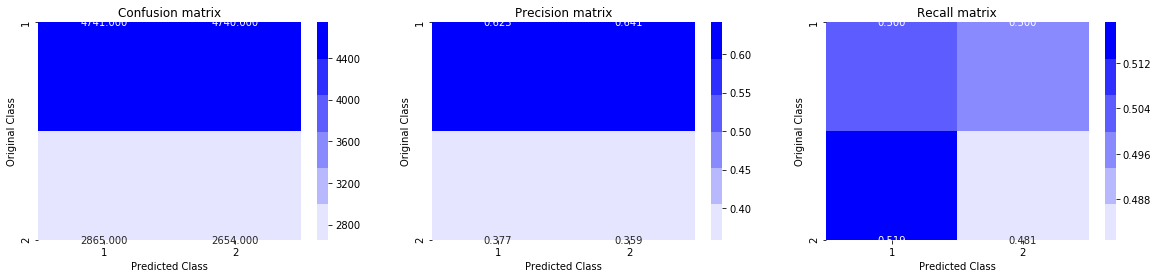

In [64]:
predicted_y = np.zeros((test_len,2)) #Just initializing the Array with : Shape = (30000,2)

for i in range(test_len):
    rand_probs = np.random.rand(1,2) #Generate Random values
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])  #Giving Values to the Array(Random Values and divide each of the numbers by their sum)

print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

---

### Stocatic Gradient Decent

-When using Gradient Descent, you should ensure that all features have a similar scale (e.g., using Scikit-Learn’s StandardScaler class), or else it will take much longer to converge.


# 4.4 Logistic Regression with hyperparameter tuning 

- Trying Logistic because our Data has high numerb of dimensions
- SGD with loss="Log" Means a Logistic regression.
- And as we learned, Wherever we use Log-loss we need to Caliberate the model.Therefore we will use :
- CalibratedClassifierCV() to caliberate the model
- Train and TEst loss being siimilar shows there is no Over-Fit 
 if train loss is very small and test loss no that small, its overfit.
- Consider Precision And Recall too.

In [1]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

# https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31

# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

#Enumerate() method adds a counter to an iterable and returns it in a form of enumerate object.
#Ex: ["eat","sleep","repeat"]  Becomes [(0, 'eat'), (1, 'sleep'), (2, 'repeat')]

For values of alpha =  1e-05 The log loss is: 0.6578466096710185
For values of alpha =  0.0001 The log loss is: 0.4634621696250374
For values of alpha =  0.001 The log loss is: 0.4752468519384105
For values of alpha =  0.01 The log loss is: 0.4639072323168484
For values of alpha =  0.1 The log loss is: 0.45672597071962956
For values of alpha =  1 The log loss is: 0.4774131100742796
For values of alpha =  10 The log loss is: 0.5172361538030938
i is : 0 Text is : 0.658
i is : 1 Text is : 0.463
i is : 2 Text is : 0.475
i is : 3 Text is : 0.464
i is : 4 Text is : 0.457
i is : 5 Text is : 0.477
i is : 6 Text is : 0.517


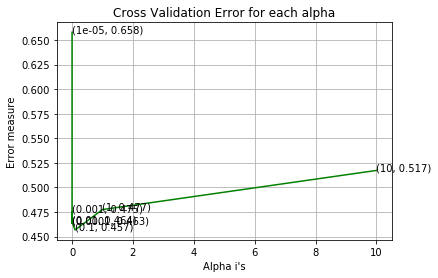

For values of best alpha =  0.1 The train log loss is: 0.44232306306338626
For values of best alpha =  0.1 The test log loss is: 0.45917788504838464
Total number of data points : 15000
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      9481
           1       0.77      0.54      0.63      5519

    accuracy                           0.77     15000
   macro avg       0.77      0.72      0.73     15000
weighted avg       0.77      0.77      0.76     15000



In [66]:
alpha = [10 ** x for x in range(-5, 2)]  #HyperParameter List
log_error_array=[] #Initialized Array to store Log_error
# Testing the HyperParameters for Logistic Regression :
for i in alpha:
    clf= SGDClassifier(alpha=i,loss="log",penalty='l2')
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
    sig_clf.fit(X_train,y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    

#PLot the Graph for Log-Loss
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    print("i is :",i,"Text is :",txt)
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#Implement the Algorithm using the Best Alphha and plot confusion Matrix
best_alpha = np.argmin(log_error_array) # This is the Best Alpha (Lowest Log Loss)

clf= SGDClassifier(alpha=alpha[best_alpha],loss="log",penalty='l2',random_state=42)
clf.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
sig_clf.fit(X_train,y_train)
predict_y = sig_clf.predict_proba(X_test)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1) #Above we used predict_proba, Here we use argmax to select 0 or q based on Higher probability score
print("Total number of data points :", len(predicted_y))
#plot_confusion_matrix(y_test, predicted_y)
print("Classification Report: \n",classification_report(y_test,predicted_y))

# Observation :
-  Log loss for Logistic with alpha 0.1 is: 0.4553985519406958 , As compared to Log loss for Random model : 0.8893385806507957
-  This is a good sign as we Have reduced the error by almost 50%, Altough our goal is to Reach 0.
-  The train log loss is: 0.47184264623543154 , The test log loss is: 0.4809830449608359 : **These Values being close means there is no Overfit**
- Precision for both classes is around 75 which is decent. Recall for Class 2 is very bad.

---

# Linear SVM with hyperparameter tuning 
- SGD with loss="hinge" Means a SVM.
- And as we learned, Wherever we use Log-loss we need to Caliberate the model.Therefore we will use :
- CalibratedClassifierCV() to caliberate the model
- Train and TEst loss being siimilar shows there is no Over-Fit 
 if train loss is very small and test loss no that small, its overfit.
- Consider Precision And Recall too.

In [18]:
alpha = [10**i for i in range(-4,2)] #Setting the values to Test for hyperParameter

log_error_array=[] #Blank Array to Store the Log-Loss list
for i in alpha:
    clf = SGDClassifier(alpha=i,loss="hinge",penalty='l1',random_state=42)
    clf.fit(X_train,y_train)
    sig_clf= CalibratedClassifierCV(clf,method="sigmoid")
    sig_clf.fit(X_train,y_train)
    predicted_y=sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test,predicted_y,labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predicted_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  0.0001 The log loss is: 0.6553513168455473
For values of alpha =  0.001 The log loss is: 0.6553513168455473
For values of alpha =  0.01 The log loss is: 0.6553513168455473
For values of alpha =  0.1 The log loss is: 0.6553513168455473
For values of alpha =  1 The log loss is: 0.6553513168455473
For values of alpha =  10 The log loss is: 0.6539221893698351


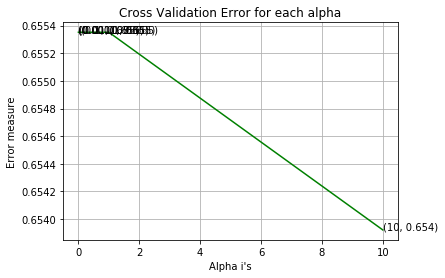

For values of best alpha =  10 The train log loss is: 0.6547263610287097
For values of best alpha =  10 The test log loss is: 0.6539221893698351
Total number of data points : 300
Classification Report: 
               precision    recall  f1-score   support

           0       0.64      1.00      0.78       191
           1       0.00      0.00      0.00       109

    accuracy                           0.64       300
   macro avg       0.32      0.50      0.39       300
weighted avg       0.41      0.64      0.50       300



In [19]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha],loss="hinge",penalty='l1',random_state=42)
clf.fit(X_train,y_train)
sig_clf= CalibratedClassifierCV(clf,method="sigmoid")
sig_clf.fit(X_train,y_train)
predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
#plot_confusion_matrix(y_test, predicted_y)
print("Classification Report: \n",classification_report(y_test,predicted_y))

# Observation :
-  Log loss for SVM with alpha 0.01 is:  0.5135127143773024 , As compared to Log loss for Random model : 0.8893385806507957
-  This is a good sign as we Have reduced the error But we got a much better Performance using Logistic Model, Altough our goal is to Reach 0.
-  The train log loss is: 0.6164904929480097 , The test log loss is: 0.6133784573048636 : **These Values being close means there is no Overfit**
- Precision for both classes is around 75 which is decent. Recall for Class 2 is very bad.

---

# XGBOOST
- Is one of the Best GBDT implementation.
- XGBOOST = GBDT + RowSampling + ColumnSampling
- It combines advantages of both GBDT and RF

- DMatrix is a internal data structure that used by XGBoost
which is optimized for both memory efficiency and training speed.
You can construct DMatrix from numpy.arrays

The XGBoost library implements the gradient boosting decision tree algorithm.

This algorithm goes by lots of different names such as gradient boosting, multiple additive regression trees, stochastic gradient boosting or gradient boosting machines.

Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made. A popular example is the AdaBoost algorithm that weights data points that are hard to predict.


Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

In [20]:
#xgboost without Sklearn

# All Parameters https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02 #learning_rate
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))

[14:07:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-logloss:0.683024	valid-logloss:0.685619
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[14:07:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[14:07:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[14:07:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[14:07:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[14:07:37] C:\Users\Administrator\Desktop\xg

[14:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[14:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[14:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[14:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[14:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[14:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[14:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[14:07:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[14:07:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[14:07:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[14:07:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[110]	train-logloss:0.282204	valid-logloss:0.460336
[14:07:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[14:07:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[14:07:41] C:\Users\Administrator\Desktop\

[14:07:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[160]	train-logloss:0.222873	valid-logloss:0.45443
[14:07:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[14:07:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[14:07:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[14:07:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[14:07:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[14:07:42] C:\Users\Administrator\Desktop\x

# Observation :
-  Log loss for XGB with alpha 0.01 is:  0.35786879575108177 , As compared to Log loss for Random model : 0.8893385806507957
-  This is a good sign as we Have Achieved The Best log-loss SO far Using XGB and the score is Good.

-  The train log loss is: 0.357869 , The test log loss is: 0.35786879575108177 : **These Values being close means there is no Overfit**


---

# HyperParameter Tuning XGBOOST
### There are 2 forms of XGBoost:

-1. xgb – this is the direct xgboost library. I will use a specific function “cv” from this library : 
https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters

-2. XGBClassifier – this is an sklearn wrapper for XGBoost. 

Refer : 

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

# Different Metrics for RandomizedSearchCV()
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter : Explain of Scoring="neg_log_loss" means Logloss.


In [13]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

## HyperParameter tuning for XGBoost 

In [17]:
param = {
        'silent': [False],
        'max_depth': [2,4,6,8,10],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3,0.5,0.75,1],
        'subsample': [0.001,0.01,0.1,0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.2,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.2,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5,0.75, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10, 100],
        'n_estimators': [1000]}



fit_params = {'eval_metric': 'logloss',
              'early_stopping_rounds': 10,
              'eval_set': [(X_train, y_train)]
              }

clf = xgb.XGBClassifier(nthread = 4)


model = RandomizedSearchCV(clf, param, n_iter=20,
                            n_jobs=1, verbose=2, cv=2,scoring='neg_log_loss', refit=False, random_state=42)


model.fit(X_train, y_train, **fit_params)


print('='*100)
print('='*100)

best_score = model.best_score_
best_params = model.best_params_

print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Best score: -0.5126202888919839
Best params: 
colsample_bylevel: 0.6
colsample_bytree: 0.2
gamma: 0.75
learning_rate: 0.75
max_depth: 6
min_child_weight: 10.0
n_estimators: 1000
reg_alpha: 1
reg_lambda: 100.0
silent: False
subsample: 0.6


# Train using Best Parameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

clf = xgb.XGBClassifier(max_depth = 10,n_estimators = 1000,learning_rate=0.1,objective='binary:logistic',min_child_weight=3.0,
                       reg_alpha = 10, colsample_bytree = 0.6,colsample_bylevel = 1.0, gamma = 0.75, reg_lambda = 50, subsample = 1.0,
                       silent = False)
clf.fit(X_train,y_train)                        
clf_2 = CalibratedClassifierCV(clf, method="sigmoid")
clf_2.fit(X_train, y_train)

predict_y = clf_2.predict_proba(X_train)
print("The log loss for Train is:",log_loss(y_train, predict_y,  eps=1e-15))

predict_y = clf_2.predict_proba(X_test)
print("The log loss for Test is:",log_loss(y_test, predict_y,  eps=1e-15))

predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
#plot_confusion_matrix(y_test, predicted_y)
print("Classification Report: \n",classification_report(y_test,predicted_y))

[13:30:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 48 pruned nodes, max_depth=10
[13:30:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 44 pruned nodes, max_depth=10
[13:30:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 36 pruned nodes, max_depth=10
[13:30:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 30 pruned nodes, max_depth=10
[13:30:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 68 pruned nodes, max_depth=10
[13:30:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 22 pruned nodes, max_depth=10
[13:30:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:

[13:32:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 70 pruned nodes, max_depth=10
[13:32:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 80 pruned nodes, max_depth=10
[13:32:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 114 pruned nodes, max_depth=10
[13:32:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 86 pruned nodes, max_depth=10
[13:32:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 96 pruned nodes, max_depth=10
[13:32:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 90 pruned nodes, max_depth=10
[13:32:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74:

[13:34:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 94 pruned nodes, max_depth=8
[13:34:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 90 pruned nodes, max_depth=10
[13:34:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 62 pruned nodes, max_depth=10
[13:34:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 88 pruned nodes, max_depth=8
[13:34:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 88 pruned nodes, max_depth=9
[13:34:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 64 pruned nodes, max_depth=10
[13:34:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[13:36:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 82 pruned nodes, max_depth=9
[13:36:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 56 pruned nodes, max_depth=10
[13:36:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 86 pruned nodes, max_depth=9
[13:36:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 64 pruned nodes, max_depth=7
[13:36:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 82 pruned nodes, max_depth=7
[13:36:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 80 pruned nodes, max_depth=9
[13:36:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[13:38:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 98 pruned nodes, max_depth=7
[13:38:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 60 pruned nodes, max_depth=8
[13:38:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 84 pruned nodes, max_depth=8
[13:38:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 82 pruned nodes, max_depth=7
[13:38:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 78 pruned nodes, max_depth=9
[13:38:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 70 pruned nodes, max_depth=6
[13:38:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:39:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 72 pruned nodes, max_depth=6
[13:39:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 70 pruned nodes, max_depth=6
[13:39:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 78 pruned nodes, max_depth=7
[13:40:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 82 pruned nodes, max_depth=7
[13:40:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 74 pruned nodes, max_depth=7
[13:40:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 74 pruned nodes, max_depth=6
[13:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:41:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 56 pruned nodes, max_depth=6
[13:41:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 60 pruned nodes, max_depth=6
[13:41:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 66 pruned nodes, max_depth=7
[13:41:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 52 pruned nodes, max_depth=7
[13:41:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 60 pruned nodes, max_depth=6
[13:41:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 66 pruned nodes, max_depth=8
[13:41:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:43:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 58 pruned nodes, max_depth=5
[13:43:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 62 pruned nodes, max_depth=6
[13:43:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 54 pruned nodes, max_depth=9
[13:43:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 60 pruned nodes, max_depth=5
[13:43:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 64 pruned nodes, max_depth=8
[13:43:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 52 pruned nodes, max_depth=7
[13:43:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:44:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 48 pruned nodes, max_depth=5
[13:44:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 58 pruned nodes, max_depth=7
[13:44:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 60 pruned nodes, max_depth=5
[13:44:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 54 pruned nodes, max_depth=5
[13:44:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 48 pruned nodes, max_depth=6
[13:44:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 42 pruned nodes, max_depth=7
[13:44:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:46:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 46 pruned nodes, max_depth=5
[13:46:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 50 pruned nodes, max_depth=7
[13:46:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 60 pruned nodes, max_depth=6
[13:46:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 52 pruned nodes, max_depth=7
[13:46:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 48 pruned nodes, max_depth=6
[13:46:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 56 pruned nodes, max_depth=8
[13:46:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:47:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 52 pruned nodes, max_depth=6
[13:47:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 56 pruned nodes, max_depth=5
[13:47:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 56 pruned nodes, max_depth=7
[13:47:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 50 pruned nodes, max_depth=7
[13:47:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 50 pruned nodes, max_depth=5
[13:47:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 52 pruned nodes, max_depth=5
[13:48:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:49:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 54 pruned nodes, max_depth=7
[13:49:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 50 pruned nodes, max_depth=6
[13:49:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 54 pruned nodes, max_depth=6
[13:49:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 58 pruned nodes, max_depth=6
[13:49:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 44 pruned nodes, max_depth=7
[13:49:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 62 pruned nodes, max_depth=5
[13:49:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:50:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 40 pruned nodes, max_depth=7
[13:50:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 42 pruned nodes, max_depth=5
[13:50:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 46 pruned nodes, max_depth=6
[13:50:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 50 pruned nodes, max_depth=6
[13:50:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 50 pruned nodes, max_depth=4
[13:50:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 50 pruned nodes, max_depth=6
[13:50:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:52:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 60 pruned nodes, max_depth=5
[13:52:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 60 pruned nodes, max_depth=4
[13:52:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 52 pruned nodes, max_depth=5
[13:52:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 46 pruned nodes, max_depth=5
[13:52:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 54 pruned nodes, max_depth=5
[13:52:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 52 pruned nodes, max_depth=7
[13:52:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:53:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 54 pruned nodes, max_depth=6
[13:53:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 34 pruned nodes, max_depth=6
[13:53:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 52 pruned nodes, max_depth=6
[13:53:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 40 pruned nodes, max_depth=6
[13:53:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 50 pruned nodes, max_depth=4
[13:53:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 44 pruned nodes, max_depth=6
[13:53:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:55:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 38 pruned nodes, max_depth=5
[13:55:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 56 pruned nodes, max_depth=4
[13:55:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 60 pruned nodes, max_depth=4
[13:55:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 42 pruned nodes, max_depth=5
[13:55:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 54 pruned nodes, max_depth=4
[13:55:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 44 pruned nodes, max_depth=5
[13:55:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prun

[13:56:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 38 pruned nodes, max_depth=4
[13:56:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 44 pruned nodes, max_depth=7
[13:56:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 56 pruned nodes, max_depth=6
[13:56:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 54 pruned nodes, max_depth=3
[13:56:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 52 pruned nodes, max_depth=6
[13:56:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 44 pruned nodes, max_depth=4
[13:56:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruni

[13:57:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 48 pruned nodes, max_depth=3
[13:58:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 54 pruned nodes, max_depth=6
[13:58:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 66 pruned nodes, max_depth=0
[13:58:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 56 pruned nodes, max_depth=0
[13:58:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 56 pruned nodes, max_depth=5
[13:58:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 52 pruned nodes, max_depth=5
[13:58:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[13:59:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[13:59:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 42 pruned nodes, max_depth=5
[13:59:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 44 pruned nodes, max_depth=4
[13:59:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 44 pruned nodes, max_depth=4
[13:59:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 42 pruned nodes, max_depth=4
[13:59:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 40 pruned nodes, max_depth=7
[13:59:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prun

[14:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 56 pruned nodes, max_depth=10
[14:00:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 36 pruned nodes, max_depth=10
[14:00:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 76 pruned nodes, max_depth=10
[14:00:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 82 pruned nodes, max_depth=10
[14:00:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 42 pruned nodes, max_depth=10
[14:00:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 52 pruned nodes, max_depth=10
[14:00:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[14:02:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 78 pruned nodes, max_depth=10
[14:02:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 86 pruned nodes, max_depth=8
[14:02:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 78 pruned nodes, max_depth=10
[14:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 56 pruned nodes, max_depth=9
[14:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 82 pruned nodes, max_depth=8
[14:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 86 pruned nodes, max_depth=7
[14:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[14:03:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 70 pruned nodes, max_depth=9
[14:03:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 76 pruned nodes, max_depth=9
[14:03:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 70 pruned nodes, max_depth=9
[14:03:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 60 pruned nodes, max_depth=10
[14:03:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 72 pruned nodes, max_depth=7
[14:03:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 68 pruned nodes, max_depth=7
[14:03:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[14:05:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 72 pruned nodes, max_depth=7
[14:05:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 52 pruned nodes, max_depth=7
[14:05:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 66 pruned nodes, max_depth=8
[14:05:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 50 pruned nodes, max_depth=9
[14:05:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 70 pruned nodes, max_depth=8
[14:05:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 64 pruned nodes, max_depth=7
[14:05:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:06:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 64 pruned nodes, max_depth=7
[14:06:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 42 pruned nodes, max_depth=6
[14:06:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 54 pruned nodes, max_depth=7
[14:06:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 50 pruned nodes, max_depth=6
[14:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 66 pruned nodes, max_depth=8
[14:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 64 pruned nodes, max_depth=6
[14:06:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:07:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 58 pruned nodes, max_depth=10
[14:07:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 56 pruned nodes, max_depth=6
[14:07:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 62 pruned nodes, max_depth=7
[14:07:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 62 pruned nodes, max_depth=6
[14:07:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 50 pruned nodes, max_depth=7
[14:07:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 52 pruned nodes, max_depth=6
[14:07:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[14:08:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 60 pruned nodes, max_depth=6
[14:09:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 62 pruned nodes, max_depth=5
[14:09:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 48 pruned nodes, max_depth=8
[14:09:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 56 pruned nodes, max_depth=5
[14:09:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 42 pruned nodes, max_depth=7
[14:09:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 46 pruned nodes, max_depth=6
[14:09:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:10:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 52 pruned nodes, max_depth=5
[14:10:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 58 pruned nodes, max_depth=5
[14:10:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 50 pruned nodes, max_depth=4
[14:10:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 46 pruned nodes, max_depth=6
[14:10:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 44 pruned nodes, max_depth=6
[14:10:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 50 pruned nodes, max_depth=7
[14:10:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:11:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 50 pruned nodes, max_depth=5
[14:11:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 48 pruned nodes, max_depth=7
[14:11:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 48 pruned nodes, max_depth=6
[14:11:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 52 pruned nodes, max_depth=5
[14:11:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 50 pruned nodes, max_depth=6
[14:11:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 38 pruned nodes, max_depth=5
[14:11:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:12:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 42 pruned nodes, max_depth=8
[14:12:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 38 pruned nodes, max_depth=6
[14:12:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 50 pruned nodes, max_depth=4
[14:12:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 52 pruned nodes, max_depth=4
[14:12:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 52 pruned nodes, max_depth=7
[14:12:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 44 pruned nodes, max_depth=6
[14:12:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:13:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 40 pruned nodes, max_depth=6
[14:13:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 52 pruned nodes, max_depth=4
[14:13:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 38 pruned nodes, max_depth=5
[14:13:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 46 pruned nodes, max_depth=7
[14:13:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 40 pruned nodes, max_depth=6
[14:13:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 36 pruned nodes, max_depth=8
[14:13:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:15:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 30 pruned nodes, max_depth=5
[14:15:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 48 pruned nodes, max_depth=3
[14:15:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 44 pruned nodes, max_depth=4
[14:15:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 42 pruned nodes, max_depth=3
[14:15:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 50 pruned nodes, max_depth=5
[14:15:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 40 pruned nodes, max_depth=4
[14:15:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:16:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 36 pruned nodes, max_depth=5
[14:16:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 38 pruned nodes, max_depth=5
[14:16:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 34 pruned nodes, max_depth=4
[14:16:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 52 pruned nodes, max_depth=5
[14:16:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 44 pruned nodes, max_depth=6
[14:16:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 40 pruned nodes, max_depth=6
[14:16:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:17:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 58 pruned nodes, max_depth=2
[14:17:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 58 pruned nodes, max_depth=4
[14:17:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 46 pruned nodes, max_depth=5
[14:17:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 36 pruned nodes, max_depth=4
[14:17:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 40 pruned nodes, max_depth=4
[14:17:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 40 pruned nodes, max_depth=4
[14:17:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruni

[14:18:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 38 pruned nodes, max_depth=4
[14:18:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 36 pruned nodes, max_depth=4
[14:18:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 42 pruned nodes, max_depth=4
[14:18:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 36 pruned nodes, max_depth=4
[14:18:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 44 pruned nodes, max_depth=4
[14:18:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 48 pruned nodes, max_depth=4
[14:18:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[14:19:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[14:19:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 36 pruned nodes, max_depth=4
[14:19:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:19:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 44 pruned nodes, max_depth=3
[14:19:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 44 pruned nodes, max_depth=4
[14:19:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 44 pruned nodes, max_depth=3
[14:19:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[14:20:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 42 pruned nodes, max_depth=3
[14:20:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 46 pruned nodes, max_depth=4
[14:20:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 48 pruned nodes, max_depth=3
[14:20:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 40 pruned nodes, max_depth=2
[14:20:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 44 pruned nodes, max_depth=5
[14:20:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 42 pruned nodes, max_depth=4
[14:20:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[14:21:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 34 pruned nodes, max_depth=5
[14:21:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 52 pruned nodes, max_depth=3
[14:21:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:21:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 40 pruned nodes, max_depth=3
[14:21:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 46 pruned nodes, max_depth=3
[14:21:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 44 pruned nodes, max_depth=3
[14:21:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[14:22:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 42 pruned nodes, max_depth=10
[14:22:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 36 pruned nodes, max_depth=10
[14:22:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 56 pruned nodes, max_depth=10
[14:22:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 48 pruned nodes, max_depth=10
[14:22:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 60 pruned nodes, max_depth=10
[14:22:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 38 pruned nodes, max_depth=10
[14:22:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[14:24:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 54 pruned nodes, max_depth=10
[14:24:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 86 pruned nodes, max_depth=10
[14:24:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 48 pruned nodes, max_depth=10
[14:24:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 94 pruned nodes, max_depth=10
[14:24:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 84 pruned nodes, max_depth=8
[14:24:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 74 pruned nodes, max_depth=9
[14:24:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree

[14:25:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 58 pruned nodes, max_depth=9
[14:25:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 68 pruned nodes, max_depth=8
[14:25:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 62 pruned nodes, max_depth=8
[14:25:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 54 pruned nodes, max_depth=7
[14:25:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 72 pruned nodes, max_depth=9
[14:25:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 52 pruned nodes, max_depth=10
[14:25:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[14:27:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 68 pruned nodes, max_depth=10
[14:27:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 50 pruned nodes, max_depth=7
[14:27:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 58 pruned nodes, max_depth=7
[14:27:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 50 pruned nodes, max_depth=8
[14:27:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 68 pruned nodes, max_depth=6
[14:27:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 70 pruned nodes, max_depth=7
[14:27:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[14:28:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 68 pruned nodes, max_depth=6
[14:28:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 48 pruned nodes, max_depth=10
[14:28:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 54 pruned nodes, max_depth=8
[14:28:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 70 pruned nodes, max_depth=7
[14:28:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 60 pruned nodes, max_depth=8
[14:28:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 50 pruned nodes, max_depth=7
[14:28:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[14:29:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 64 pruned nodes, max_depth=6
[14:29:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 54 pruned nodes, max_depth=6
[14:29:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 48 pruned nodes, max_depth=6
[14:29:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 42 pruned nodes, max_depth=8
[14:29:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 56 pruned nodes, max_depth=8
[14:29:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 52 pruned nodes, max_depth=7
[14:29:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:30:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 62 pruned nodes, max_depth=6
[14:31:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 40 pruned nodes, max_depth=6
[14:31:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 50 pruned nodes, max_depth=6
[14:31:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 52 pruned nodes, max_depth=5
[14:31:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 54 pruned nodes, max_depth=7
[14:31:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 54 pruned nodes, max_depth=5
[14:31:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:32:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 38 pruned nodes, max_depth=8
[14:32:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 52 pruned nodes, max_depth=5
[14:32:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 50 pruned nodes, max_depth=6
[14:32:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 50 pruned nodes, max_depth=7
[14:32:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 48 pruned nodes, max_depth=6
[14:32:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 54 pruned nodes, max_depth=6
[14:32:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:33:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 56 pruned nodes, max_depth=6
[14:33:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 42 pruned nodes, max_depth=6
[14:33:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 46 pruned nodes, max_depth=7
[14:33:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 44 pruned nodes, max_depth=6
[14:33:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 60 pruned nodes, max_depth=5
[14:33:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 40 pruned nodes, max_depth=6
[14:33:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:34:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 48 pruned nodes, max_depth=5
[14:34:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 40 pruned nodes, max_depth=7
[14:34:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 38 pruned nodes, max_depth=4
[14:34:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 46 pruned nodes, max_depth=6
[14:34:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 50 pruned nodes, max_depth=5
[14:34:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 46 pruned nodes, max_depth=5
[14:34:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:35:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 54 pruned nodes, max_depth=6
[14:35:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 40 pruned nodes, max_depth=5
[14:35:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 38 pruned nodes, max_depth=5
[14:35:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 48 pruned nodes, max_depth=4
[14:35:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 34 pruned nodes, max_depth=5
[14:35:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 42 pruned nodes, max_depth=5
[14:35:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:36:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 36 pruned nodes, max_depth=6
[14:36:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 60 pruned nodes, max_depth=4
[14:36:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 52 pruned nodes, max_depth=7
[14:36:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 44 pruned nodes, max_depth=5
[14:36:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 38 pruned nodes, max_depth=5
[14:37:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 38 pruned nodes, max_depth=5
[14:37:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prun

[14:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 38 pruned nodes, max_depth=6
[14:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 44 pruned nodes, max_depth=5
[14:38:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 38 pruned nodes, max_depth=6
[14:38:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 38 pruned nodes, max_depth=4
[14:38:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 42 pruned nodes, max_depth=5
[14:38:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 38 pruned nodes, max_depth=6
[14:38:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:39:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 44 pruned nodes, max_depth=3
[14:39:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 34 pruned nodes, max_depth=4
[14:39:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 38 pruned nodes, max_depth=6
[14:39:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 36 pruned nodes, max_depth=5
[14:39:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 38 pruned nodes, max_depth=4
[14:39:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 40 pruned nodes, max_depth=5
[14:39:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prun

[14:40:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 46 pruned nodes, max_depth=4
[14:40:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 44 pruned nodes, max_depth=6
[14:40:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:40:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 52 pruned nodes, max_depth=4
[14:40:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 40 pruned nodes, max_depth=4
[14:40:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 38 pruned nodes, max_depth=6
[14:40:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruni

[14:41:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 40 pruned nodes, max_depth=5
[14:41:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 34 pruned nodes, max_depth=4
[14:41:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 32 pruned nodes, max_depth=5
[14:41:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 42 pruned nodes, max_depth=3
[14:41:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 40 pruned nodes, max_depth=4
[14:41:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 48 pruned nodes, max_depth=3
[14:41:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruni

[14:42:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 50 pruned nodes, max_depth=3
[14:42:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 48 pruned nodes, max_depth=3
[14:42:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 40 pruned nodes, max_depth=4
[14:42:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[14:42:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[14:42:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:42:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[14:43:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[14:43:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 34 pruned nodes, max_depth=3
[14:43:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 36 pruned nodes, max_depth=5
[14:43:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 28 pruned nodes, max_depth=3
[14:43:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 34 pruned nodes, max_depth=4
[14:43:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 42 pruned nodes, max_depth=5
[14:43:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prun

[14:44:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 38 pruned nodes, max_depth=3
[14:44:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 40 pruned nodes, max_depth=4
[14:44:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[14:44:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 32 pruned nodes, max_depth=3
[14:44:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[14:44:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 30 pruned nodes, max_depth=3
[14:44:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[14:46:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 92 pruned nodes, max_depth=10
[14:46:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 78 pruned nodes, max_depth=10
[14:46:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 54 pruned nodes, max_depth=10
[14:46:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 64 pruned nodes, max_depth=10
[14:46:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 64 pruned nodes, max_depth=10
[14:46:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 76 pruned nodes, max_depth=10
[14:46:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[14:47:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 78 pruned nodes, max_depth=10
[14:47:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 68 pruned nodes, max_depth=10
[14:47:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 80 pruned nodes, max_depth=9
[14:47:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 76 pruned nodes, max_depth=10
[14:47:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 56 pruned nodes, max_depth=9
[14:47:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 92 pruned nodes, max_depth=9
[14:47:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[14:48:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 84 pruned nodes, max_depth=8
[14:49:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 70 pruned nodes, max_depth=8
[14:49:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 64 pruned nodes, max_depth=8
[14:49:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 64 pruned nodes, max_depth=8
[14:49:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 76 pruned nodes, max_depth=8
[14:49:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 80 pruned nodes, max_depth=7
[14:49:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:50:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 64 pruned nodes, max_depth=8
[14:50:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 60 pruned nodes, max_depth=9
[14:50:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 66 pruned nodes, max_depth=8
[14:50:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 72 pruned nodes, max_depth=6
[14:50:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 72 pruned nodes, max_depth=7
[14:50:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 68 pruned nodes, max_depth=7
[14:50:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:51:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 54 pruned nodes, max_depth=6
[14:51:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 60 pruned nodes, max_depth=7
[14:51:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 52 pruned nodes, max_depth=7
[14:51:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 66 pruned nodes, max_depth=6
[14:51:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 52 pruned nodes, max_depth=6
[14:51:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 60 pruned nodes, max_depth=9
[14:51:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:53:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 36 pruned nodes, max_depth=6
[14:53:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 58 pruned nodes, max_depth=5
[14:53:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 58 pruned nodes, max_depth=7
[14:53:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 44 pruned nodes, max_depth=6
[14:53:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 42 pruned nodes, max_depth=6
[14:53:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 52 pruned nodes, max_depth=5
[14:53:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:54:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 38 pruned nodes, max_depth=7
[14:54:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 58 pruned nodes, max_depth=5
[14:54:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 66 pruned nodes, max_depth=6
[14:54:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 44 pruned nodes, max_depth=7
[14:54:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 48 pruned nodes, max_depth=6
[14:54:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 52 pruned nodes, max_depth=7
[14:54:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:55:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 44 pruned nodes, max_depth=5
[14:55:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 50 pruned nodes, max_depth=5
[14:55:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 52 pruned nodes, max_depth=5
[14:55:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 40 pruned nodes, max_depth=5
[14:55:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 56 pruned nodes, max_depth=6
[14:55:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 44 pruned nodes, max_depth=5
[14:55:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:57:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 48 pruned nodes, max_depth=6
[14:57:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 46 pruned nodes, max_depth=6
[14:57:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 48 pruned nodes, max_depth=5
[14:57:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 52 pruned nodes, max_depth=5
[14:57:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 44 pruned nodes, max_depth=7
[14:57:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 54 pruned nodes, max_depth=4
[14:57:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:58:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 38 pruned nodes, max_depth=6
[14:58:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 48 pruned nodes, max_depth=5
[14:58:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 50 pruned nodes, max_depth=5
[14:58:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 46 pruned nodes, max_depth=5
[14:58:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 50 pruned nodes, max_depth=5
[14:58:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 52 pruned nodes, max_depth=5
[14:58:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:59:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 42 pruned nodes, max_depth=4
[14:59:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 36 pruned nodes, max_depth=4
[14:59:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 44 pruned nodes, max_depth=4
[14:59:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 56 pruned nodes, max_depth=4
[14:59:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 42 pruned nodes, max_depth=6
[14:59:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 42 pruned nodes, max_depth=4
[14:59:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[15:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 52 pruned nodes, max_depth=5
[15:00:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 58 pruned nodes, max_depth=4
[15:00:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 48 pruned nodes, max_depth=3
[15:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 38 pruned nodes, max_depth=5
[15:00:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 44 pruned nodes, max_depth=5
[15:00:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 48 pruned nodes, max_depth=3
[15:00:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prun

[15:02:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 50 pruned nodes, max_depth=4
[15:02:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 44 pruned nodes, max_depth=5
[15:02:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 48 pruned nodes, max_depth=5
[15:02:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 42 pruned nodes, max_depth=4
[15:02:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 50 pruned nodes, max_depth=3
[15:02:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 46 pruned nodes, max_depth=4
[15:02:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prun

[15:03:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 36 pruned nodes, max_depth=4
[15:03:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 42 pruned nodes, max_depth=4
[15:03:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 34 pruned nodes, max_depth=8
[15:03:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 42 pruned nodes, max_depth=6
[15:03:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 34 pruned nodes, max_depth=4
[15:03:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 42 pruned nodes, max_depth=4
[15:03:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[15:04:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 34 pruned nodes, max_depth=5
[15:04:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 38 pruned nodes, max_depth=5
[15:04:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 40 pruned nodes, max_depth=5
[15:04:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 38 pruned nodes, max_depth=3
[15:04:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 42 pruned nodes, max_depth=5
[15:04:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 46 pruned nodes, max_depth=4
[15:04:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[15:05:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 44 pruned nodes, max_depth=5
[15:05:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 36 pruned nodes, max_depth=5
[15:05:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 38 pruned nodes, max_depth=3
[15:05:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 42 pruned nodes, max_depth=3
[15:05:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 40 pruned nodes, max_depth=4
[15:05:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 42 pruned nodes, max_depth=6
[15:05:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruni

[15:06:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 36 pruned nodes, max_depth=7
[15:06:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 40 pruned nodes, max_depth=5
[15:06:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 38 pruned nodes, max_depth=4
[15:06:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 44 pruned nodes, max_depth=3
[15:06:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 32 pruned nodes, max_depth=4
[15:07:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 44 pruned nodes, max_depth=5
[15:07:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[15:08:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 48 pruned nodes, max_depth=3
[15:08:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[15:08:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 38 pruned nodes, max_depth=4
[15:08:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 44 pruned nodes, max_depth=3
[15:08:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 30 pruned nodes, max_depth=4
[15:08:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 42 pruned nodes, max_depth=4
[15:08:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning

[15:09:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 58 pruned nodes, max_depth=9
[15:09:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 60 pruned nodes, max_depth=10
[15:09:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 46 pruned nodes, max_depth=10
[15:09:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 46 pruned nodes, max_depth=10
[15:09:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 42 pruned nodes, max_depth=10
[15:09:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 58 pruned nodes, max_depth=10
[15:09:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[15:10:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 74 pruned nodes, max_depth=9
[15:10:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 76 pruned nodes, max_depth=10
[15:10:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 70 pruned nodes, max_depth=9
[15:10:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 60 pruned nodes, max_depth=10
[15:10:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 74 pruned nodes, max_depth=8
[15:10:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 46 pruned nodes, max_depth=10
[15:10:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[15:12:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 76 pruned nodes, max_depth=8
[15:12:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 82 pruned nodes, max_depth=9
[15:12:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 62 pruned nodes, max_depth=7
[15:12:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 48 pruned nodes, max_depth=7
[15:12:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 62 pruned nodes, max_depth=9
[15:12:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 60 pruned nodes, max_depth=9
[15:12:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[15:13:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 66 pruned nodes, max_depth=7
[15:13:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 46 pruned nodes, max_depth=9
[15:13:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 54 pruned nodes, max_depth=7
[15:13:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 62 pruned nodes, max_depth=8
[15:13:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 68 pruned nodes, max_depth=8
[15:13:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 62 pruned nodes, max_depth=8
[15:13:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[15:14:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 66 pruned nodes, max_depth=6
[15:14:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 52 pruned nodes, max_depth=7
[15:14:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 72 pruned nodes, max_depth=6
[15:15:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 68 pruned nodes, max_depth=7
[15:15:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 56 pruned nodes, max_depth=7
[15:15:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 68 pruned nodes, max_depth=7
[15:15:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[15:16:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 50 pruned nodes, max_depth=7
[15:16:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 56 pruned nodes, max_depth=8
[15:16:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 46 pruned nodes, max_depth=10
[15:16:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 62 pruned nodes, max_depth=6
[15:16:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 46 pruned nodes, max_depth=6
[15:16:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 60 pruned nodes, max_depth=6
[15:16:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[15:17:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 48 pruned nodes, max_depth=6
[15:17:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 44 pruned nodes, max_depth=6
[15:17:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 44 pruned nodes, max_depth=5
[15:17:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 54 pruned nodes, max_depth=5
[15:17:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 48 pruned nodes, max_depth=5
[15:17:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 46 pruned nodes, max_depth=7
[15:17:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[15:18:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 54 pruned nodes, max_depth=4
[15:18:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 48 pruned nodes, max_depth=6
[15:18:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 50 pruned nodes, max_depth=6
[15:18:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 48 pruned nodes, max_depth=6
[15:18:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 56 pruned nodes, max_depth=5
[15:18:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 52 pruned nodes, max_depth=6
[15:18:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[15:19:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 48 pruned nodes, max_depth=5
[15:19:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 46 pruned nodes, max_depth=6
[15:19:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 52 pruned nodes, max_depth=5
[15:19:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 56 pruned nodes, max_depth=5
[15:19:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 44 pruned nodes, max_depth=6
[15:20:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 48 pruned nodes, max_depth=7
[15:20:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[15:21:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 54 pruned nodes, max_depth=7
[15:21:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 42 pruned nodes, max_depth=5
[15:21:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 42 pruned nodes, max_depth=6
[15:21:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 62 pruned nodes, max_depth=5
[15:21:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 32 pruned nodes, max_depth=7
[15:21:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 40 pruned nodes, max_depth=5
[15:21:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[15:22:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 38 pruned nodes, max_depth=5
[15:22:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 40 pruned nodes, max_depth=5
[15:22:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 52 pruned nodes, max_depth=5
[15:22:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 46 pruned nodes, max_depth=4
[15:22:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 56 pruned nodes, max_depth=4
[15:22:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 38 pruned nodes, max_depth=4
[15:22:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[15:23:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 40 pruned nodes, max_depth=5
[15:23:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 50 pruned nodes, max_depth=4
[15:23:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 40 pruned nodes, max_depth=5
[15:23:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 44 pruned nodes, max_depth=4
[15:23:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 42 pruned nodes, max_depth=6
[15:23:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 34 pruned nodes, max_depth=4
[15:23:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru